In [1]:
import numpy as np
import pandas as pd
from EMDPM.model_generator import generate_logistic_model
from EMDPM.synthetic_data_generator import generate_synthetic_data
from EMDPM.visualization import (
    plot_biomarker_trajectories,
    plot_true_observations,
    plot_initial_beta_guess,
    plot_theta_fit_comparison,
    plot_theta_error_history,
    plot_beta_overlay,
    plot_beta_error_history,
    plot_lse,
    plot_cog_regression_history
)
from EMDPM.utils import solve_system
from EMDPM.em_transformer_rework import EM
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("/data01/bgutman/MRI_data/PPMI/data_ppmi_pd.csv")
df_K = pd.read_csv("/data01/bgutman/LEGACY/Skoltech/datasets/Connectomes/mean_NORM_con_22.csv")
n_biomarkers = 10

## remove non-longitudinal observations
print("original size:", df.shape)
relevant_cols = [col for col in df.columns if col.startswith(('L_', 'R_')) and ('_thickavg' in col or '_thickavg_resid' in col)]
relevant_cols += ["MCATOT", "TD_score", "PIGD_score"]
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=relevant_cols)

print("after drop na", df.shape)
subj_counts = df['subj_id'].value_counts()
num_unique = (subj_counts == 1).sum()
print("one time subj_id:", num_unique)

longitudinal_ids = subj_counts[subj_counts > 1].index
df = df[df['subj_id'].isin(longitudinal_ids)].copy()
df = df.drop_duplicates(subset=["subj_id", "time"])
print("after drop dupes", df.shape)

small_region_set = ['L_inferiorparietal_thickavg',
'R_inferiorparietal_thickavg',
'L_inferiortemporal_thickavg',
'R_inferiortemporal_thickavg',
'L_precuneus_thickavg',
'R_precuneus_thickavg',
'L_isthmuscingulate_thickavg',
'R_isthmuscingulate_thickavg',
'L_lateraloccipital_thickavg',
'R_lateraloccipital_thickavg']

small_region_set_resid = ['L_inferiorparietal_thickavg_resid',
'R_inferiorparietal_thickavg_resid',
'L_inferiortemporal_thickavg_resid',
'R_inferiortemporal_thickavg_resid',
'L_precuneus_thickavg_resid',
'R_precuneus_thickavg_resid',
'L_isthmuscingulate_thickavg_resid',
'R_isthmuscingulate_thickavg_resid',
'L_lateraloccipital_thickavg_resid',
'R_lateraloccipital_thickavg_resid']

X = df[[col for col in df.columns if (col.startswith(('L_', 'R_')) and col.endswith('_thickavg') and not col.endswith('_thickavg_resid'))]]
X_resid = df[small_region_set_resid]
X_resid = X_resid.to_numpy()
X_resid = np.max(X_resid, axis=0) - X_resid

# X = df[small_region_set]
X = X.to_numpy()
X = np.max(X, axis=0) - X



print("nans in X:", np.isnan(X).sum())
print("infs in X:", np.isinf(X).sum())

print("nans X_resid:", np.isnan(X_resid).sum())
print("infs X_resid:", np.isinf(X_resid).sum())

## connectivity matrix to numpy
K = df_K.drop(df_K.columns[0], axis=1).to_numpy()
np.fill_diagonal(K, 0)
print(K.shape, type(K))

# normalization
row_sums = K.sum(axis=1)
median_row_sum = np.median(row_sums)
K = K / median_row_sum

# region_index = [6, 40, 7, 41, 23, 57, 8, 42, 9, 43]
# K = np.take(np.take(K,region_index,axis=0), region_index, axis=1)

t_max = 30
step = 0.001


print("X.size: ", X.shape, "X_resid.size: ", X_resid.shape)

ids = df["subj_id"].to_numpy()
dt = df["time"].to_numpy()/12 # convert to years
#cog = df["MCATOT"].values#,"TD_score","PIGD_score"]].values
cog = df[["MCATOT","TD_score","PIGD_score"]].to_numpy()
nhy = df["NHY"].to_numpy()
print("nans in cog:", np.isnan(cog).sum())
print("infs in cog:", np.isinf(cog).sum())


original size: (880, 250)
after drop na (868, 250)
one time subj_id: 227
after drop dupes (504, 250)
nans in X: 0
infs in X: 0
nans X_resid: 0
infs X_resid: 0
(68, 68) <class 'numpy.ndarray'>
X.size:  (504, 68) X_resid.size:  (504, 10)
nans in cog: 0
infs in cog: 0


In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression

def compute_patient_avg_slope(X, dt, ids):
    unique_ids = np.unique(ids)
    pid_to_slope = {}
    
    for pid in unique_ids:
        mask = (ids == pid)
        t = dt[mask].reshape(-1,1)
        Xi = X[mask]                       
        if Xi.shape[0] < 2:
            pid_to_slope[pid] = 0.0
            continue
        
        slopes = []
        for j in range(Xi.shape[1]):
            y = Xi[:, j]
            # simple linear fit: biomarker_j = a * dt + b
            a = np.linalg.lstsq(np.hstack([t, np.ones_like(t)]), y, rcond=None)[0][0]
            slopes.append(a)
        pid_to_slope[pid] = np.mean(slopes)
        
    return pid_to_slope

import pandas as pd

def prepare_glm_data(df, X, dt, ids, cog_df):
    """
    - df: original DataFrame with columns for MCATOT, PIGD_score, TD_score, subj_id
    - X, dt, ids: as before
    - cog_df: DataFrame with same rows as X, containing cog scores (MCATOT,PIGD,TD)
    
    Returns a DataFrame ready for mixed‐effects modeling.
    """
    # Scale dt per patient to [0,1]
    df_proc = df.copy()
    df_proc['dt'] = dt
    df_proc['id'] = ids
    
    # Shift so min(dt)=0, then scale so max(dt)=1 for each patient
    df_proc['dt_min'] = df_proc.groupby('id')['dt'].transform('min')
    df_proc['dt_max'] = df_proc.groupby('id')['dt'].transform('max')
    df_proc['dt_scaled'] = (df_proc['dt'] - df_proc['dt_min']) / (df_proc['dt_max'] - df_proc['dt_min'] + 1e-8)
    
    # Add cognitive scores
    df_proc[['MCATOT','PIGD_score','TD_score']] = cog_df[['MCATOT','PIGD_score','TD_score']]
    
    # Add avg_slope
    pid_to_slope = compute_patient_avg_slope(X, dt, ids)
    df_proc['avg_slope'] = df_proc['id'].map(pid_to_slope)
    
    return df_proc

import statsmodels.formula.api as smf

def init_beta_mixedlm(df_proc, t_max):
    """
    Fit: dt_scaled ~ MCATOT + PIGD_score + TD_score + avg_slope
    Random intercept per patient.
    Returns: dict subj_id -> random intercept * t_max (to rescale to original time).
    """
    # Use dt_scaled as response; random intercept on 'id'
    model = smf.mixedlm("dt_scaled ~ MCATOT + PIGD_score + TD_score + avg_slope",
                         data=df_proc,
                         groups=df_proc["id"],
                         re_formula="1")
    result = model.fit()
    
    # Extract random intercepts
    rand_eff = result.random_effects  # dict pid->{'Group': val}
    pid_to_beta = {pid: eff["Group"] * t_max for pid, eff in rand_eff.items()}
    return pid_to_beta

# 1) Prepare df_proc
df_proc = prepare_glm_data(
    df=df,   # must contain 'subj_id' column
    X=X, dt=dt, ids=ids,
    cog_df=df[["MCATOT","PIGD_score","TD_score"]]  # columns: MCATOT, PIGD_score, TD_score
)

# 2) Fit and get beta_init
pid_to_beta = init_beta_mixedlm(df_proc, t_max=t_max)

# 3) Convert to an array aligned with np.unique(ids)
unique_ids = np.unique(ids)
beta_init = np.array([pid_to_beta.get(pid, 0.0) for pid in unique_ids])


/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/dsemchin/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

(array([ 1.,  0.,  2.,  4.,  1.,  7., 17., 36., 56., 22.]),
 array([ 0.        ,  3.03916505,  6.07833011,  9.11749516, 12.15666021,
        15.19582527, 18.23499032, 21.27415537, 24.31332043, 27.35248548,
        30.39165053]),
 <BarContainer object of 10 artists>)

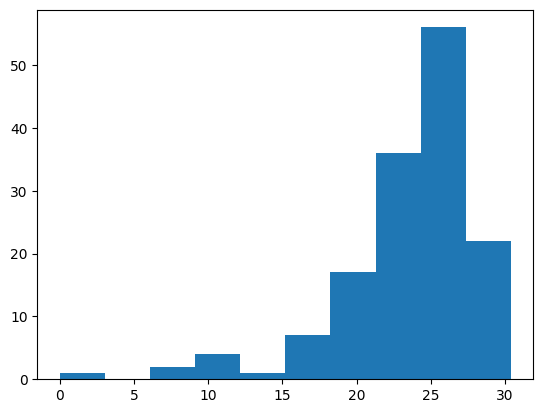

In [21]:

initial_beta = beta_init + np.abs(min(beta_init))
plt.hist(initial_beta*1.5e5)


In [22]:
path = "/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter10_jac1_cog0_lf05_lsk0.npz"
em_model_0 = EM(num_iterations=10, t_max=t_max, step=step,
                 use_jacobian=True, lambda_cog=0.01, lambda_f=0.7, lambda_scalar=0.5,
                 initial_beta=initial_beta,dt=dt, ids=ids, cog=cog, K=K, save_path=path)
# use_jacobian=True, lambda_cog=0.01, lambda_f=0.05, lambda_scalar=0.0)
em_model_0.fit(X=X, y=None)

initial conditions:
n_patients: 146, n_obs: 504
initial f: [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602  0.04133209 0.08230453
 0.0022666  0.01390147 0.09860839 0.09937478 0.08214235 0.08432822
 0.04013177 0.06671307 0.08373361 0.09839783 0.02023919 0.03501122
 0.04284144 0.01783596 0.09961038 0.09075806 0.02514527 0.00911193
 0.08359398 0.01764515 0.01661423 0.07885973 0.07766215 0.04404987
 0.09696822 0.082177   0.05962018 0.00122331 0.05374854 0.04256232
 0.04619497 0.04704044 0.02556865 0.01364169 0.04599744 0.07974691
 0.07593373 0.03570143 0.06885477 0.07627636 0.07265386 0.08249544
 0.09601051 0.04935155 0.06479739 0.06791427 0.02254441 0.00444622
 0.03445908 0.07018692 0.06961764 0.09191688 0.02265776 0.09207324
 0.06548166 0.07676195]
initial s: [0.10711755 0.28260825 2.16554111 1.09902366 1.78421727 2.15874837
 1.36243194 1.69084338 2.16695433 1.00498682 0.94543585 1.55525368
 2.5998545  1.57441885 1.22037802 2.6

  0%|          | 0/10 [00:00<?, ?it/s]

Execution time: 28.7819 seconds


 10%|█         | 1/10 [00:31<04:43, 31.47s/it]

Execution time: 30.8496 seconds


 20%|██        | 2/10 [01:08<04:39, 34.88s/it]

Execution time: 8.3356 seconds


 30%|███       | 3/10 [01:23<02:59, 25.63s/it]

Execution time: 8.3920 seconds


 40%|████      | 4/10 [01:37<02:07, 21.23s/it]

Execution time: 8.6499 seconds


 50%|█████     | 5/10 [01:51<01:32, 18.59s/it]

Execution time: 8.4261 seconds


 60%|██████    | 6/10 [02:04<01:06, 16.61s/it]

Execution time: 8.6514 seconds


 70%|███████   | 7/10 [02:17<00:45, 15.32s/it]

Execution time: 8.6507 seconds


 80%|████████  | 8/10 [02:29<00:28, 14.39s/it]

Execution time: 348.8116 seconds


 90%|█████████ | 9/10 [08:25<02:01, 121.25s/it]

Execution time: 430.2868 seconds


100%|██████████| 10/10 [15:40<00:00, 94.05s/it] 


SUMMARY:
initial theta:  [0.02132917 0.0153129  0.06642505 0.06843318 0.09331644 0.075149
 0.09268624 0.09472834 0.0866778  0.0012602 ]
final theta:  [0.         0.75963783 0.         1.68086397 1.48144584 0.05331227
 0.         0.         0.36039468 0.        ]
Saved histories to /home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter10_jac1_cog0_lf05_lsk0.npz.npz


EM(K=array([[0.        , 0.        , 0.04686961, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04686961, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]]),
   cog=array([[28.,  0.,  2.],
       [27.,  7.,  0.],
       [29.,  3.,  1.],
       ...,
       [30., 13.,  0.],
       [28.,  4.,  0.],
       [21.,  3.,  3.]]),
   dt=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.,...
       23.97486126, 22.10394871, 23.14454204, 30.        , 16.86434769,
       30.        , 17.50570041, 22.50618633, 17.95453079, 22.84387965,
       26.92046772]),
   lambda_cog=0.01, lambda_f=0.7, lambda_scalar=0.5, num_iterations=10,
   rng=Generator(PCG64) at 0x7F1139487BC0,
   save_path='/home/dsemchin/Progression_models_simulations/EMDPM/experiments/real_data_PPMI/ppmi_iter10_jac1_cog0_lf05_lsk0.npz',
   step=0.001, t_max=30)

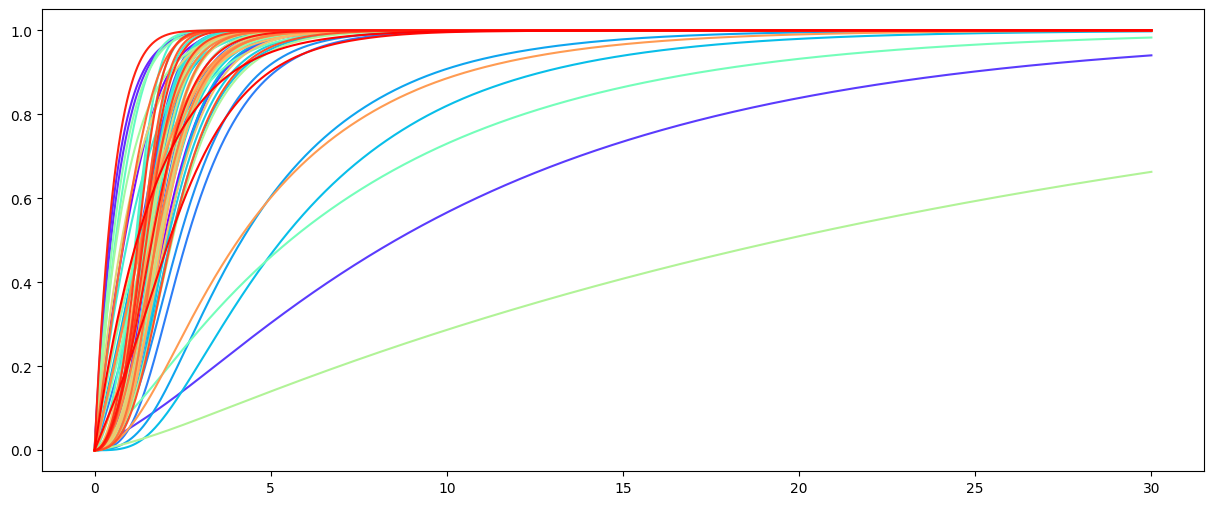

In [24]:
n_biomarkers = 68
t_span = np.linspace(0, t_max, int(t_max/step))

theta_history = em_model_0.theta_history
beta_history = em_model_0.beta_history
lse_history = em_model_0.lse_history

# final params
final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = final_theta[-1]
final_model = solve_system(final_x0, final_f, K, t_span, final_scalar_K)

plt.figure(figsize=(15,6))
colors = plt.cm.rainbow(np.linspace(0, 1, n_biomarkers))
for b in range(n_biomarkers):
    plt.plot(t_span, final_model[b], color = colors[b])
plt.show()

initial theta:
f:  [0.021 0.015 0.066 0.068 0.093 0.075 0.093 0.095 0.087 0.001 0.041 0.082
 0.002 0.014 0.099 0.099 0.082 0.084 0.04  0.067 0.084 0.098 0.02  0.035
 0.043 0.018 0.1   0.091 0.025 0.009 0.084 0.018 0.017 0.079 0.078 0.044
 0.097 0.082 0.06  0.001 0.054 0.043 0.046 0.047 0.026 0.014 0.046 0.08
 0.076 0.036 0.069 0.076 0.073 0.082 0.096 0.049 0.065 0.068 0.023 0.004
 0.034 0.07  0.07  0.092 0.023 0.092 0.065 0.077]
s:  [0.107 0.283 2.166 1.099 1.784 2.159 1.362 1.691 2.167 1.005 0.945 1.555
 2.6   1.574 1.22  2.622 2.1   2.248 0.688 2.178 1.473 0.57  1.638 0.705
 0.696 0.348 0.26  0.285 2.912 0.496 2.476 0.394 2.746 0.352 1.887 0.926
 2.476 0.299 1.757 0.117 0.618 0.298 1.408 2.526 1.906 2.351 1.313 0.124
 2.81  0.229 1.335 2.849 2.623 0.293 0.564 2.898 0.958 1.601 2.735 0.751
 2.604 2.038 2.488 2.459 1.806 1.07  2.827 1.299]
s_k:  2.199
final theta:
f:  [0.    0.76  0.    1.681 1.481 0.053 0.    0.    0.36  0.   ]
s:  [0.315 0.768 0.514 0.555 0.728 0.356 0.286 0.306 0.56

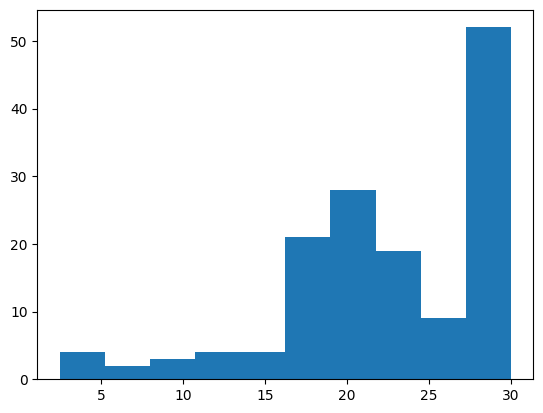

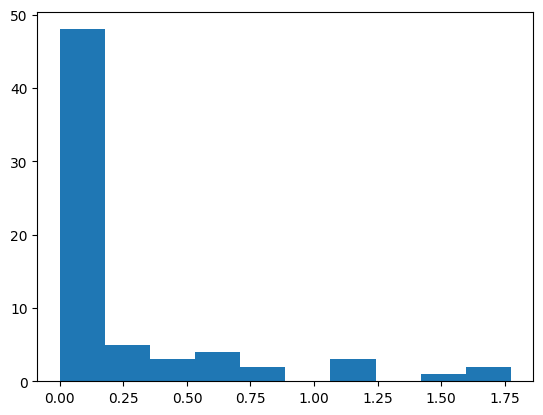

In [25]:
initial_theta = theta_history[:,0]
initial_x0 = np.zeros(n_biomarkers)
initial_f = initial_theta[0:n_biomarkers]
initial_s = initial_theta[n_biomarkers:2*n_biomarkers]
initial_scalar_K = initial_theta[-1]
#initial_model = solve_system(initial_x0, initial_f, K, t_span, initial_scalar_K)

print("initial theta:")
print("f: ", np.round(initial_f, 3))
print("s: ", np.round(initial_s, 3))
print("s_k: ", initial_theta[-1])

final_theta = theta_history[:,-1]
final_x0 = np.zeros(n_biomarkers)
final_f = final_theta[0:n_biomarkers]
final_s = final_theta[n_biomarkers:2*n_biomarkers]
final_scalar_K = initial_theta[-1]

print("final theta:")
print("f: ", np.round(final_f[0:10], 3))
print("s: ", np.round(final_s[0:10], 3))
print("s_k: ", final_theta[-1])

initial_beta = beta_history[:, 0]
final_beta = beta_history[:, -1]

## Beta comparison:
print("\nBETA SUMMARY:")
print("beta initial: ", np.round(initial_beta[0:10], 3))
print("beta final: ", np.round(final_beta[0:10], 3))

print(len(beta_history[:,-1]))
plt.figure()
plt.hist(beta_history[:,-1])
plt.show()
plt.figure()
plt.hist(final_theta[:n_biomarkers])
plt.show()

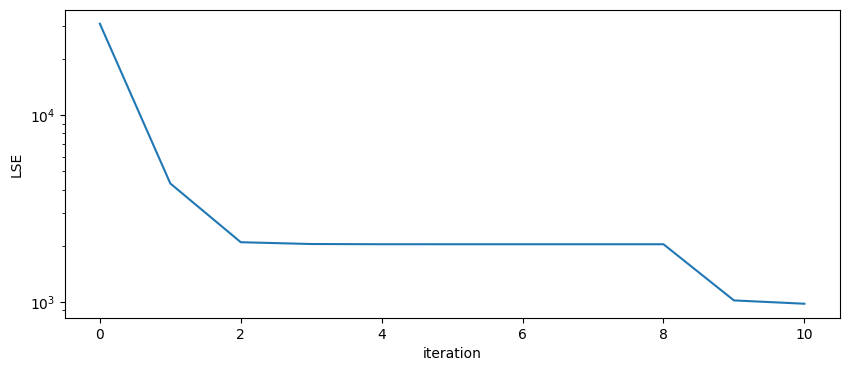

In [26]:
plot_lse(lse_history)

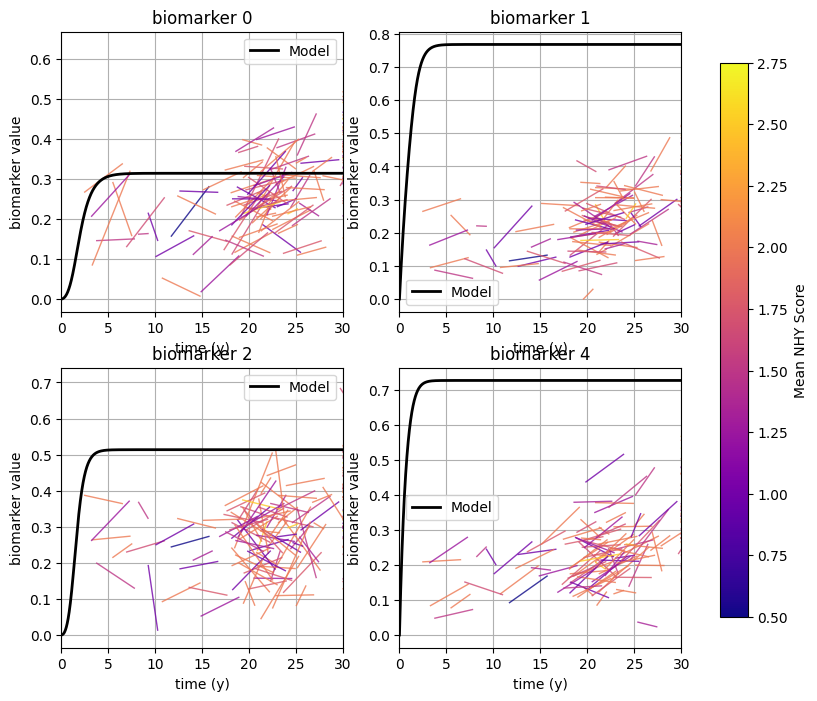

In [30]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import matplotlib.cm as cm
import matplotlib.colors as colors

def plot_all_patient_regression_lines_grid_nhy(X, dt, ids, beta, t_span, nhy, model=None,
                                               biomarker_indices=None, biomarker_labels=None,
                                               max_lines=500, t_max=40):
    """
    Plot regression lines per patient for each selected biomarker on a grid of subplots.
    Each line is color-coded by the patient's mean NHY score.
    """
    if biomarker_indices is None:
        biomarker_indices = list(range(X.shape[1]))

    unique_ids = np.unique(ids)
    pid_to_index = {pid: idx for idx, pid in enumerate(unique_ids)}

    # Compute mean NHY score per patient
    mean_nhy = {}
    for pid in unique_ids:
        nhy_i = nhy[ids == pid]
        mean_nhy[pid] = np.mean(nhy_i) if len(nhy_i) > 0 else np.nan

    # Colormap setup
    cmap = cm.plasma  # or viridis, inferno, etc.
    nhy_vals = np.array(list(mean_nhy.values()))
    norm = colors.Normalize(vmin=np.nanmin(nhy_vals), vmax=np.nanmax(nhy_vals))

    n_plots = len(biomarker_indices)
    n_cols = math.ceil(np.sqrt(n_plots))
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for plot_idx, j in enumerate(biomarker_indices):
        ax = axes[plot_idx]
        title = biomarker_labels[j] if biomarker_labels else f"biomarker {j}"
        ax.set_title(f"{title}")
        ax.set_xlabel("time (y)")
        ax.set_ylabel("biomarker value")

        line_count = 0
        for pid in unique_ids:
            if line_count >= max_lines:
                break
            mask = (ids == pid)
            if np.sum(mask) < 2:
                continue

            X_i = X[mask, j]
            dt_i = dt[mask]
            beta_i = beta[pid_to_index[pid]]
            t_ij = dt_i + beta_i

            nhy_mean = mean_nhy[pid]
            if np.isnan(nhy_mean):
                continue
            line_color = cmap(norm(nhy_mean))

            model_i = LinearRegression().fit(t_ij.reshape(-1, 1), X_i)
            t_fit = np.linspace(t_ij.min(), t_ij.max(), 20)
            x_fit = model_i.predict(t_fit.reshape(-1, 1))

            ax.plot(t_fit, x_fit, color=line_color, alpha=0.8, linewidth=1)
            line_count += 1

        # Plot model-predicted trajectory
        if model is not None:
            ax.plot(t_span, model[j], color='black', linewidth=2, label="Model")
            ax.legend()

        ax.grid(True)
        ax.set_xlim(0, t_max)

    # Remove unused axes
    for k in range(n_plots, len(axes)):
        fig.delaxes(axes[k])

    # Add colorbar for NHY scale
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.tolist(), orientation='vertical', shrink=0.9)
    cbar.set_label("Mean NHY Score")

    plt.show()

plot_all_patient_regression_lines_grid_nhy(
    X=X_resid,
    dt=dt,
    ids=ids,
    beta=beta_history[:, -1],
    t_span=t_span,
    nhy=nhy,  # your NHY array
    model=final_model * final_s[:, None],
    biomarker_indices=[0, 1, 2, 4],
    biomarker_labels=None,
    max_lines=500,
    t_max=t_span[-1]
)


/tmp/ipykernel_14519/3563002270.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="NHY", y="t_ij", palette="plasma", inner="box")


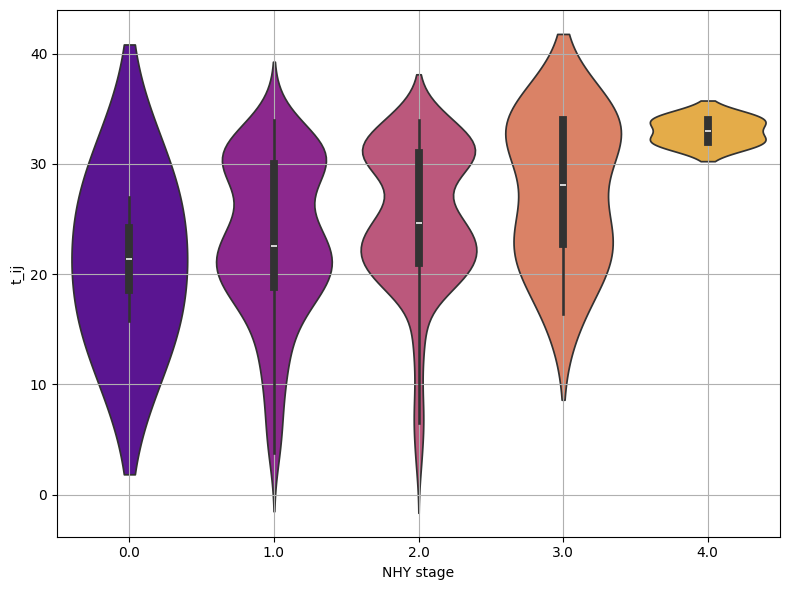

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_violin_nhy_vs_tij(dt, ids, beta, nhy):
    unique_ids = np.unique(ids)
    pid_to_index = {pid: idx for idx, pid in enumerate(unique_ids)}
    t_ij = np.array([dt_i + beta[pid_to_index[pid]] for dt_i, pid in zip(dt, ids)])
    
    df = pd.DataFrame({
        "t_ij": t_ij,
        "NHY": nhy
    })

    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df, x="NHY", y="t_ij", palette="plasma", inner="box")
    plt.xlabel("NHY stage")
    plt.ylabel("t_ij")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_violin_nhy_vs_tij(dt=dt, ids=ids, beta=beta_history[:, -1], nhy=nhy)


In [ ]:
plt.hist(nhy)
print(sum(nhy==0))

2


7.40626956117814e-05
30.0
Empty DataFrame
Columns: [NHY, beta]
Index: []
             beta
count  146.000000
mean    24.410112
std     11.327757
min      0.000074
25%     30.000000
50%     30.000000
75%     30.000000
max     30.000000


/tmp/ipykernel_14519/1108660201.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pair, x="NHY", y="beta", palette="plasma", inner="box", legend=False)


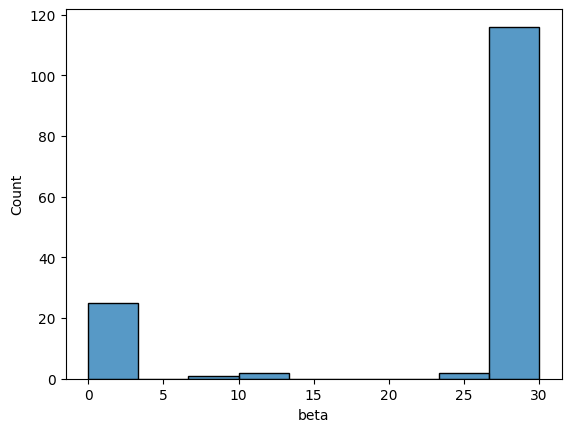

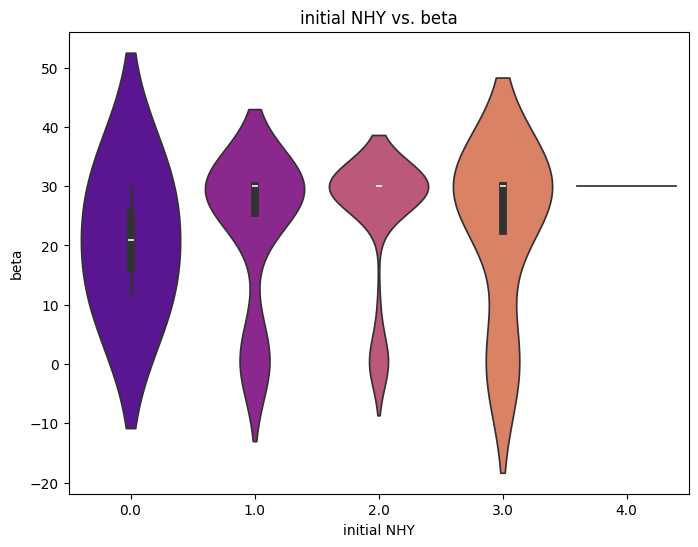

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_violin_nhy_vs_beta(ids, dt, nhy, beta):
    unique_ids = np.unique(ids)
    pair = []

    pid_to_beta = {pid: beta[i] for i, pid in enumerate(unique_ids)}
    
    for pid in unique_ids:
        mask = (ids == pid)
        dt_i = dt[mask]
        nhy_i = nhy[mask]
        idx_min_dt = np.argmax(dt_i)
        nhy_first = nhy_i[idx_min_dt]
        beta_i = pid_to_beta[pid]

        pair.append({"NHY": nhy_first, "beta": beta_i})

    df_pair = pd.DataFrame(pair)
    
    df_pair["NHY"] = df_pair["NHY"].astype("category")
    df_pair["beta"] = df_pair["beta"].astype(float)
    
    print(min(df_pair["beta"]))
    print(max(df_pair["beta"]))
    sns.histplot(data=df_pair, x="beta")
    
    print(df_pair[df_pair["beta"] < 0])  # confirm no negatives
    print(df_pair.describe())

    

    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df_pair, x="NHY", y="beta", palette="plasma", inner="box", legend=False)
    plt.title("initial NHY vs. beta")
    plt.xlabel("initial NHY")
    plt.ylabel("beta")
    plt.show()
    
    

plot_violin_nhy_vs_beta(ids=ids, dt=dt, nhy=nhy, beta=beta_history[:, 1])
